In [1]:
import sys
import os
import warnings
import time

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", "..", ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [2]:
from src.database.db_connection import *
from src.database.preparation import *
from src.utilities.step1_simplify_fds import *
from src.utilities.step2_clustering_and_generating_repairs import *
from src.utilities.step3_convert_back_to_db import *
from src.utilities.step4_group_similar_sentences import *
from src.evaluation.metrics import *
from src.database.db_connection import *

In [3]:
engine = create_engine_for_db()

In [4]:
fd_constraints = [(['sid', 'university'],['sname', 'address', 'postcode', 'emailid', 'phonenum'])]

In [5]:
fd_constraints = simplify_FDs(fd_constraints)

In [6]:
fd_constraints

[(['sid', 'university'], ['sname']),
 (['sid', 'university'], ['address']),
 (['sid', 'university'], ['postcode']),
 (['sid', 'university'], ['emailid']),
 (['sid', 'university'], ['phonenum'])]

In [7]:
violation_levels = violation_levels = [
    {'target_violation_fraction': 0.50, 'dups_per_cluster': (3, 4), 'cells_corrupted': (1, 1)},
    {'target_violation_fraction': 0.50, 'dups_per_cluster': (3, 4), 'cells_corrupted': (2, 2)},
    {'target_violation_fraction': 0.50, 'dups_per_cluster': (3, 4), 'cells_corrupted': (3, 3)},
    {'target_violation_fraction': 0.50, 'dups_per_cluster': (3, 4), 'cells_corrupted': (4, 4)},
    {'target_violation_fraction': 0.50, 'dups_per_cluster': (3, 4), 'cells_corrupted': (5, 5)}
]

num_inconsistent_relations = 10

delete_cost = 2
update_cost = 1
eps=1e-9
prob_type = 'UNIFORM'
constraint_hardness = [1.0] * len(fd_constraints)

query_file_name_expected_Prob = "../../../queries/FP/synthetic/Students_truth.sql"
query_file_name_actual_Prob = "../../../queries/FP/synthetic/Students_prob.sql"
algorithm_name = 'PRA'
old_table_name = ''
new_table_name = ''

vio_fracs = []
times_taken = []
num_rvs_used = []
cartesian_possible_list = []
cartesian_computed_list = []
min_cost_actions_list = []
avg_precision_prob_list = []
avg_recall_prob_list = []
avg_coverage_prob_list = []
avg_noise_prob_list = []

In [8]:
for j,violation_level in enumerate(violation_levels,start=1):
    total_time = 0.0
    total_precision_prob, total_recall_prob,total_coverage_prob, total_noise_prob = 0.0, 0.0, 0.0, 0.0
    total_rvs = 0
    total_cartesian_possible = 0
    total_cartesian_computed = 0
    min_cost_actions_suggested = 0
    
    target_violation_fraction = violation_level['target_violation_fraction']
    dups_per_cluster = violation_level['dups_per_cluster']
    cells_corrupted = violation_level['cells_corrupted']
    for i in range(1, num_inconsistent_relations + 1):
        table_name = f"students_{j}_{i}"
        inconsistent_df = pd.read_sql_table(table_name, con=engine, schema="prototype_fp_1")
        with engine.begin() as connection:
            connection.execute(text("""
            TRUNCATE TABLE prototype_fp_1.students_prob
            RESTART IDENTITY
            CASCADE;
            """))
            connection.execute(text("""
            UPDATE prototype_fp_1."_dict"
            SET dict = dictionary('')
            WHERE name = :name;
            """), {"name": "students_dict"})

        start = time.perf_counter()
        inconsistent_df = preprocess_data(inconsistent_df)
        actions,cluster_ids,rv_probs = compute_actions(inconsistent_df, fd_constraints, constraint_hardness,delete_cost, update_cost,eps,prob_type)
        all_actions,cartesian_possible,cartesian_computed = min_cost_actions_pruned(cluster_ids,actions,delete_cost,update_cost)
        
        total_cartesian_possible += cartesian_possible
        total_cartesian_computed += cartesian_computed
        min_cost_actions_suggested += len(all_actions)
        
        repaired_versions =  apply_combined_actions(inconsistent_df, all_actions, uuid_col="uuid")
        repaired_versions = pd.concat(repaired_versions, ignore_index=True)
        repaired_versions = repaired_versions.drop(columns=["uuid"])
        #rv_probabilities = filter_and_condition_min_cost_rvs(rv_probs, repaired_versions)
        rv_probabilities = rv_probs
        repaired_df = group_similar_rows_together(repaired_versions)
        repaired_df.to_sql('students_prob',engine,schema='prototype_fp_1',index=False,if_exists='append')
        entries = [f"{k}:{v}" for k, v in rv_probabilities.items()]
        joined = ';'.join(entries)

        update_stmt = f"UPDATE prototype_fp_1._dict\nSET dict=add(dict, '{joined}')\nWHERE name='students_dict';"
        with engine.begin() as connection:
            connection.execute(text(update_stmt))
        elapsed = time.perf_counter() - start
        total_rvs += len(rv_probabilities)
        total_time += elapsed

        results_Prob,results_with_truth_set_prob = calculate_expected_values(query_file_name_expected_Prob, query_file_name_actual_Prob, algorithm_name,
                                                                             engine,old_table_name,new_table_name)
        precision_prob, recall_prob,coverage_prob, noise_prob = summarize_results(results_Prob)

        print(f"\nViolation Level {j}: Processed inconsistent relation {i} table name: {table_name}")
        print(f"Time taken {elapsed}")
        print(f"Number of RVs used {int(len(rv_probabilities))}")
        print(f"Possible Repair Actions (cartesian product) {int(cartesian_possible)}")
        print(f"Computed Repair Actions {int(cartesian_computed)}")
        print(f"Min cost Repair Actions suggested {int(len(all_actions))}")
        print(f"Precision Probabilistic: {precision_prob:.4f}")
        print(f"Recall Probabilistic: {recall_prob:.4f}")
        print(f"Coverage Probabilistic: {coverage_prob:.4f}")
        print(f"Noise Probabilistic: {noise_prob:.4f}")
        total_precision_prob += precision_prob
        total_recall_prob += recall_prob
        total_coverage_prob += coverage_prob
        total_noise_prob += noise_prob
        
        
    
    avg_time_violation_level = total_time/num_inconsistent_relations
    avg_number_of_rvs = total_rvs/num_inconsistent_relations
    avg_max_repair_actions_possible = total_cartesian_possible/num_inconsistent_relations
    avg_max_repair_actions_computed = total_cartesian_computed/num_inconsistent_relations
    avg_min_cost_actions_suggested = min_cost_actions_suggested/num_inconsistent_relations
    avg_precision_prob = total_precision_prob / num_inconsistent_relations
    avg_recall_prob = total_recall_prob / num_inconsistent_relations
    avg_coverage_prob = total_coverage_prob / num_inconsistent_relations
    avg_noise_prob = total_noise_prob / num_inconsistent_relations
    
    print(f"\nViolation Level {j}: Average time taken {avg_time_violation_level}")
    print(f"Violation Level {j}: Average number of RVs used {int(avg_number_of_rvs)}")
    print(f"Violation Level {j}: Average Max possible repair actions {int(avg_max_repair_actions_possible)}")
    print(f"Violation Level {j}: Average Max computed repair actions {int(avg_max_repair_actions_computed)}")
    print(f"Violation Level {j}: Min cost repair actions suggested {int(avg_min_cost_actions_suggested)}")
    print(f"Average Precision Probabilistic for violation level {j}: {avg_precision_prob:.4f}")
    print(f"Average Recall Probabilistic for violation level {j}: {avg_recall_prob:.4f}")
    print(f"Average Coverage Probabilistic for violation level {j}: {avg_coverage_prob:.4f}")
    print(f"Average Noise Probabilistic for violation level {j}: {avg_noise_prob:.4f}")

    vio_fracs.append(violation_level['dups_per_cluster'])
    times_taken.append(float(avg_time_violation_level))
    num_rvs_used.append(int(avg_number_of_rvs))
    cartesian_possible_list.append(int(avg_max_repair_actions_possible))
    cartesian_computed_list.append(int(avg_max_repair_actions_computed))
    min_cost_actions_list.append(int(avg_min_cost_actions_suggested))
    avg_precision_prob_list.append(float(avg_precision_prob))
    avg_recall_prob_list.append(float(avg_recall_prob))
    avg_coverage_prob_list.append(float(avg_coverage_prob))
    avg_noise_prob_list.append(float(avg_noise_prob))


Violation Level 1: Processed inconsistent relation 1 table name: students_1_1
Time taken 0.08283059997484088
Number of RVs used 32
Possible Repair Actions (cartesian product) 38
Computed Repair Actions 5
Min cost Repair Actions suggested 5
Precision Probabilistic: 0.9427
Recall Probabilistic: 0.5768
Coverage Probabilistic: 1.0000
Noise Probabilistic: 0.0573

Violation Level 1: Processed inconsistent relation 2 table name: students_1_2
Time taken 0.07462969998596236
Number of RVs used 32
Possible Repair Actions (cartesian product) 47
Computed Repair Actions 5
Min cost Repair Actions suggested 5
Precision Probabilistic: 0.9181
Recall Probabilistic: 0.5349
Coverage Probabilistic: 0.9397
Noise Probabilistic: 0.0819

Violation Level 1: Processed inconsistent relation 3 table name: students_1_3
Time taken 0.07424980000359938
Number of RVs used 30
Possible Repair Actions (cartesian product) 45
Computed Repair Actions 5
Min cost Repair Actions suggested 5
Precision Probabilistic: 0.9421
Recal

In [38]:
vio_fracs = [1,2,3,4,5]

In [40]:
metrics = [
    ("Time taken (s)", times_taken),
    ("Number of RVs", num_rvs_used),
    ("Cartesian product of Repair Actions", cartesian_possible_list),
    ("Computed Repair Actions", cartesian_computed_list),
    ("Min-cost Repair Actions Suggested", min_cost_actions_list),
]

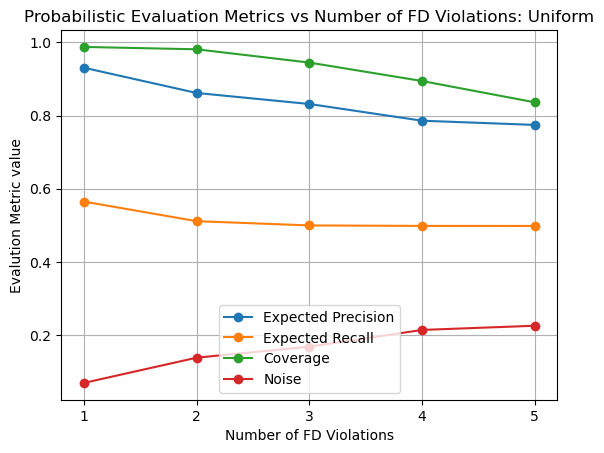

In [42]:
plt.figure()
plt.plot(vio_fracs, avg_precision_prob_list, marker='o', label="Expected Precision")
plt.plot(vio_fracs, avg_recall_prob_list, marker='o', label="Expected Recall")
plt.plot(vio_fracs, avg_coverage_prob_list, marker='o', label="Coverage")
plt.plot(vio_fracs, avg_noise_prob_list, marker='o', label="Noise")
plt.xlabel("Number of FD Violations")
plt.ylabel("Evalution Metric value")
plt.title("Probabilistic Evaluation Metrics vs Number of FD Violations: Uniform")
plt.grid(True)
plt.legend()
plt.xticks(vio_fracs)
plt.show()

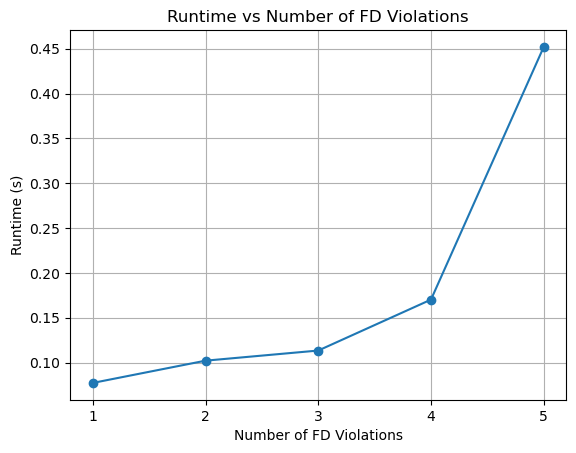

In [43]:
# 1) Time vs violation fraction
plt.figure()
plt.plot(vio_fracs, times_taken, marker='o')
plt.xlabel("Number of FD Violations")
plt.ylabel("Runtime (s)")
plt.title("Runtime vs Number of FD Violations")
plt.grid(True)
plt.xticks(vio_fracs)
plt.show()

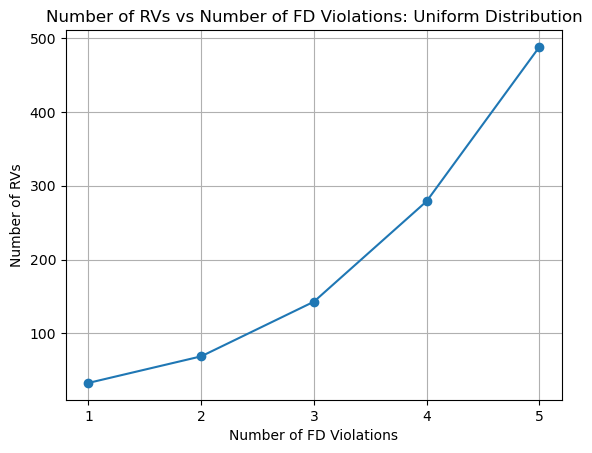

In [45]:
# 2) #RVs vs violation fraction
plt.figure()
plt.plot(vio_fracs, num_rvs_used, marker='o')
plt.xlabel("Number of FD Violations")
plt.ylabel("Number of RVs")
plt.title("Number of RVs vs Number of FD Violations: Uniform Distribution")
plt.grid(True)
plt.xticks(vio_fracs)
plt.show()

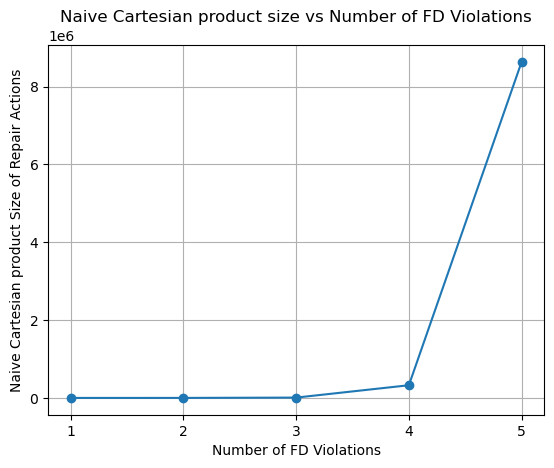

In [46]:
# 3) Cartesian possible vs violation fraction
plt.figure()
plt.plot(vio_fracs, cartesian_possible_list, marker='o')
plt.xlabel("Number of FD Violations")
plt.ylabel("Naive Cartesian product Size of Repair Actions")
plt.title("Naive Cartesian product size vs Number of FD Violations")
plt.grid(True)
plt.xticks(vio_fracs)
plt.show()

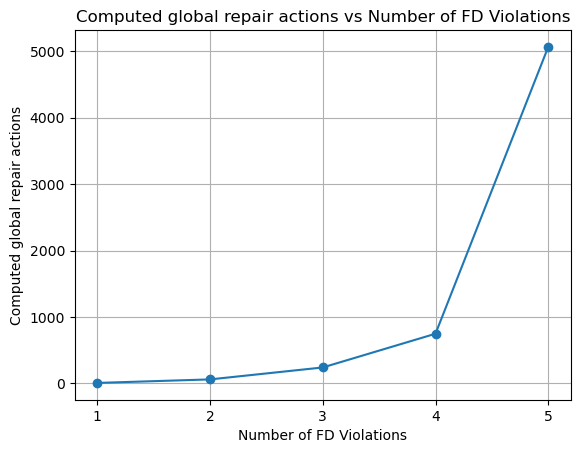

In [48]:
# 4) Cartesian computed vs violation fraction
plt.figure()
plt.plot(vio_fracs, cartesian_computed_list, marker='o')
plt.xlabel("Number of FD Violations")
plt.ylabel("Computed global repair actions")
plt.title("Computed global repair actions vs Number of FD Violations")
plt.grid(True)
plt.xticks(vio_fracs)
plt.show()

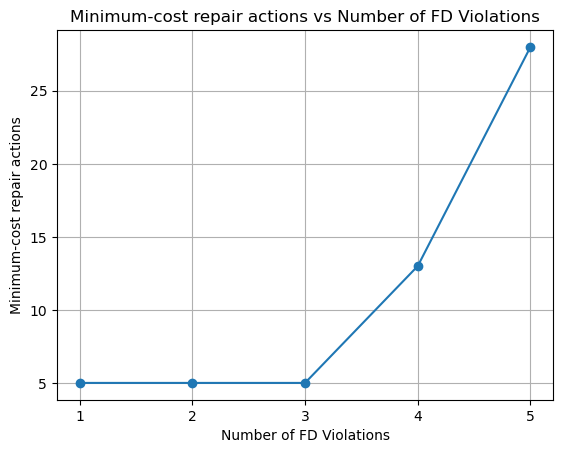

In [51]:
# 5) Min-cost actions suggested vs violation fraction
plt.figure()
plt.plot(vio_fracs, min_cost_actions_list, marker='o')
plt.xlabel("Number of FD Violations")
plt.ylabel("Minimum-cost repair actions")
plt.title("Minimum-cost repair actions vs Number of FD Violations")
plt.grid(True)
plt.xticks(vio_fracs)
plt.show()